# Sprint　深層学習スクラッチ　ニューラルネットワーク  
  
＜目的＞  
- スクラッチを通してニューラルネットワークの基礎を理解する
- 画像データの扱い方を知る  

＜MNISTデータセット＞  
ニューラルネットワークスクラッチの検証にはMNISTデータセットを使用します。各種ライブラリやサイトからダウンロードできますが、ここでは深層学習フレームワークのKerasを用います。以下のコードを実行すればデータセットをダウンロードし、展開まで行えます。  

《MNISTとは？》  
画像分類のための定番データセットで、手書き数字認識を行います。このデータセットには訓練用6万枚、テスト用1万枚の28×28ピクセルの白黒画像、およびそれらが0〜9のどの数字であるかというラベルが含まれています。  
 

《画像データとは？》  
デジタル画像は点の集合で、これをピクセルと呼びます。一般的に白黒画像であればピクセルには0〜255の値が含まれます。一方、カラー画像であればR（赤）、G（緑）、B（青）それぞれに対応する0〜255の値が含まれます。機械学習をする上では、この0〜255の値一つひとつが特徴量として扱われます。0〜255は符号なしの8ビット整数で表せる範囲になるため、NumPyであれば「uint8」型の変数として保持できます。

In [49]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import copy
from sklearn import metrics 
from scipy.special import expit

In [28]:
# データセットのロード、確認
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

＜平滑化＞  
(1, 28, 28)の各画像を、(1, 784)に変換します。これまで学んできた機械学習手法や、今回扱う全結合層のみのニューラルネットワークではこの形で扱います。全てのピクセルが一列になっていることを、 **平滑化（flatten）** してあるという風に表現します。

In [29]:
# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

＜画像データの可視化＞  
画像データを可視化します。``plt.imshow``に渡します。

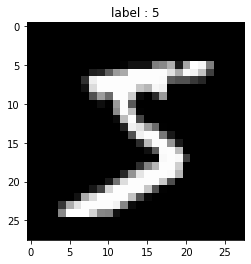

In [30]:
# 可視化
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

《発展的話題》  
画像データは符号なし8ビット整数のuint8型で保持されることが一般的ですが、``plt.imshow``はより自由な配列を画像として表示することが可能です。例えば、以下のようにマイナスの値を持ったfloat64型の浮動小数点であってもエラーにはならないし、先ほどと全く同じ風に表示されます。

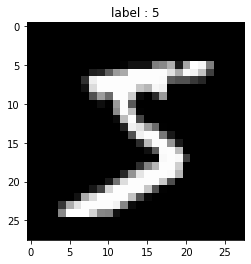

[-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
 -105.35]


In [31]:
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # float型に変換
image -= 105.35 # 意図的に負の小数値を作り出してみる
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()
print(image[0]) # 値を確認

＜前処理＞  
画像は0から255のuint8型で表されますが、機械学習をする上では0から1のfloat型で扱うことになります。以下のコードで変換可能です。

In [32]:
# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


＜one hot incoding＞  
正解ラベルは0から9の整数ですが、ニューラルネットワークで多クラス分類を行う際には **one-hot表現** に変換します。scikit-learnの``OneHotEncoder``を使用したコードが以下です。このone-hot表現による値はそのラベルである確率を示していることになるため、float型で扱います。

In [33]:
# one-hot encode
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


＜分割＞  
訓練データ6万枚の内2割を検証データとして分割してください。訓練データが48000枚、検証データが12000枚となります。

In [34]:
# 分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


### ＜ニューラルネットワークスクラッチ＞  

ニューラルネットワークのクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

今回は多クラス分類を行う3層のニューラルネットワークを作成します。層の数などは固定した上でニューラルネットワークの基本を学びます。次のSprintで層を自由に変えられる設計にしていきます。

**＜ミニバッチ処理＞**  
これまでの機械学習スクラッチでは、全てのサンプルを一度に計算していました。しかし、ニューラルネットワークではデータを分割して入力する **確率的勾配降下法** が一般的です。分割した際のひとかたまりを **ミニバッチ** 、そのサンプル数を **バッチサイズ** と呼びます。

今回はバッチサイズを20とします。今回使う訓練データは48000枚ですから、48000÷20で2400回の更新を繰り返すことになります。ニューラルネットワークではこれを2400回 **イテレーション（iteration）** すると呼びます。訓練データを一度全て見ると1回の **エポック（epoch）** が終わったことになります。このエポックを複数回繰り返し、学習が完了します。

これを実現するための簡素なイテレータを用意しました。for文で呼び出すと、ミニバッチを取得できます。

In [35]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

### 【問題1】重みの初期値を決めるコードの作成  
ニューラルネットワークの各層の重みの初期値を決めるコードを作成してください。  
重みの初期値は様々な方法が提案されていますが、今回はガウス分布による単純な初期化を行います。バイアスに関しても同様です。  
以下のコードを参考にしてください。標準偏差の値sigmaはハイパーパラメータです。発展的な重みの初期化方法については次のSprintで扱います。

### 【問題2】フォワードプロパゲーションの実装  
三層のニューラルネットワークの **フォワードプロパゲーション** を作成してください。以下の説明ではノード数は1層目は400、2層目は200としますが、変更しても構いません。  
各層の数式を以下に示します。今回はそれぞれの記号が表す配列が、実装上どのようなndarrayのshapeになるかを併記してあります。

「1層目」
$$
A_1 = X \cdot W_1 + B_1
$$

$X$ : 特徴量ベクトル (batch_size, n_features)  
$W_1$ : 1層目の重み (n_features, n_nodes1)  
$B_1$ : 1層目のバイアス (n_nodes1,)  
$A_1$ : 出力 (batch_size, n_nodes1)  

「1層目の活性化関数」
$$
Z_1 = f(A_1)
$$

$f()$ : 活性化関数  
$Z_1$ 出力 (batch_size, n_nodes1)  


「2層目」
$$
A_2 = Z_1 \cdot W_2 + B_2
$$

$W_2$ : 2層目の重み (n_nodes1, n_nodes2)  
$B_2$ : 2層目のバイアス (n_nodes2,)  
$A_2$ : 出力 (batch_size, n_nodes2)  

「2層目の活性化関数」
$$
Z_2 = f(A_2)
$$

$f()$ : 活性化関数  
$Z_2$ 出力 (batch_size, n_nodes2)  


「3層目（出力層）」
$$
A_3 = Z_2 \cdot W_3 + B_3
$$

$W_3$ : 3層目の重み (n_nodes2, n_output)  
$B_3$ : 3層目のバイアス (n_output,)  
$A_3$ : 出力 (batch_size, n_output)  


「3層目の活性化関数」
$$
Z_3 = softmax(A_3)
$$

$softmax()$ : ソフトマックス関数  
$Z_3$ : 出力 (batch_size, n_output)  

$Z_3$ は各ラベル（0〜9）に対する確率の配列である。


**＜活性化関数（フォワードプロバゲーション）＞**  
活性化関数を作成し、フォワードプロパゲーションの中で使用します。切り替えられるように実装することを推奨しますが、片方でも構いません。

「シグモイド関数」
$$
f(Z) = sigmoid(A) = \frac{1}{1+exp(-A)}
$$
指数関数 exp(-A) の計算はnp.expを使用してください。


「ハイパボリックタンジェント関数」  
次の数式で表されますが、``np.tanh``ひとつで実現できます。
$$
f(Z) = tanh(A) = \frac{exp(A) - exp(-A)}{exp(A) + exp(-A)}
$$

＊現在ではこれらの代わりにReLUと呼ばれる活性化関数が一般的です。次のSprintで扱います。

「ソフトマックス関数」  
ソフトマックス関数を作成し、フォワードプロパゲーションの中で使用します。これも活性化関数の一種ですが、多クラス分類の出力層で使われる特性上、区別して扱われることが多いです。  
$$
Z_{3\_k} = \frac{exp(A_{3\_k})}{\sum_{i=1}^{n_c}exp(A_{3\_i})}
$$

$Z_{3_k}$ : $k$ 番目のクラスの確率ベクトル (batch_size,)  
$A_{3_k}$ : $k$ 番目のクラスにあたる前の層からのベクトル (batch_size,)  
$n_c$ : クラスの数、n_output。今回のMNISTでは10。  

分母は全てのクラスに相当する値を指数関数に通した上で足し合わせたものです。その中で、分子に $k$ 番目のクラスを持ってくることで、 $k$ 番目のクラスである確率が求まります。

これを10クラス分計算し、合わせたものが $Z_3$ です。

### 【問題3】交差エントロピー誤差の実装  
関数（損失関数）を作成します。  
多クラス分類の目的関数である交差エントロピー誤差 L は次の数式です。

$$
L = - \frac{1}{n_b}\sum_{j}^{n_b}\sum_{k}^{n_c}y_{jk} log(z_{3\_jk})
$$

$y_{ij}$ : $j$ 番目のサンプルの $k$ 番目のクラスの正解ラベル（one-hot表現で0か1のスカラー）  
$z_{3_ij}$ : $j$ 番目のサンプルの $k$ 番目のクラスの確率（スカラー）  
$n_{b}$ : バッチサイズ、batch_size  
$n_{c}$ : クラスの数、n_output（今回のMNISTでは10）

サンプル1つあたりの誤差が求まります。

### 【問題4】バックプロパゲーションの実装  
三層のニューラルネットワークのバックプロパゲーションを作成してください。確率的勾配降下法を行う部分です。

数式を以下に示します。

まず、$i$層目の重みとバイアスの更新式です。 $W_i$ と $B_i$ に対し、更新後の $W_i^{\prime}$ と $B_i^{\prime}$ は次の数式で求められます。

$$
W_i^{\prime} = W_i - \alpha \frac{\partial L}{\partial W_i} \\
B_i^{\prime} = B_i - \alpha \frac{\partial L}{\partial B_i}
$$

$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）  
$\frac{\partial L}{\partial W_i}$ : $W_i$ に関する損失 $L$ の勾配  
$\frac{\partial L}{\partial B_i}$ : $B_i$ に関する損失 $L$ の勾配  

＊この勾配はミニバッチのサンプル数分の合計または平均を考えます。ここでは合計を計算します。

この更新方法はSprint3線形回帰やsprint4ロジスティック回帰における最急降下法と同様です。より効果的な更新方法が知られており、それは次のSprintで扱います。

勾配 $\frac{\partial L}{\partial W_i}$ や $\frac{\partial L}{\partial B_i}$ を求めるために、バックプロパゲーションを行います。以下の数式です。ハイパボリックタンジェント関数を使用した例を載せました。シグモイド関数の場合の数式はその後ろにあります。

「3層目」
$$
\frac{\partial L}{\partial A_3} = Z_{3} - Y\\
\frac{\partial L}{\partial B_3} = \sum_{j}^{n_b}\frac{\partial L}{\partial A_{3\_j}}\\
\frac{\partial L}{\partial W_3} = Z_{2}^{T}\cdot \frac{\partial L}{\partial A_3}\\
\frac{\partial L}{\partial Z_2} = \frac{\partial L}{\partial A_3} \cdot W_3^T
$$

$\frac{\partial L}{\partial A_3}$ : $A_3$ に関する損失 $L$ の勾配 (batch_size, n_output)  
$\frac{\partial L}{\partial A_{3_j}}$ : $j$番目のサンプルの$A_3$ に関する損失 $L$ の勾配 (n_nodes2,)  
$\frac{\partial L}{\partial B_3}$ : $B_3$ に関する損失 $L$ の勾配 (n_output,)  
$\frac{\partial L}{\partial W_3}$ : $W_3$ に関する損失 $L$ の勾配 (n_nodes2, n_output)  
$\frac{\partial L}{\partial Z_2}$ : $Z_2$ に関する損失 $L$ の勾配 (batch_size, n_nodes2)
$Z_{3}$ : ソフトマックス関数の出力 (batch_size, n_nodes2)  
$Y$ : 正解ラベル (batch_size, n_output)  
$Z_{2}$ : 2層目の活性化関数の出力 (batch_size, n_nodes2)  
$W_3$ : 3層目の重み (n_nodes2, n_output)  


「2層目」
$$
\frac{\partial L}{\partial A_2} = \frac{\partial L}{\partial Z_2} \odot \{1-tanh^2(A_{2})\}\\
\frac{\partial L}{\partial B_2} = \sum_{j}^{n_b}\frac{\partial L}{\partial A_{2\_j}}\\
\frac{\partial L}{\partial W_2} = Z_{1}^T \cdot \frac{\partial L}{\partial A_2}\\
\frac{\partial L}{\partial Z_1} = \frac{\partial L}{\partial A_2} \cdot W_2^T
$$

$\frac{\partial L}{\partial A_2}$ : $A_2$ に関する損失 $L$ の勾配 (batch_size, n_nodes2)  
$\frac{\partial L}{\partial A_{2_j}}$ : $j$番目のサンプルの$A_2$ に関する損失 $L$ の勾配 (n_nodes2,)  
$\frac{\partial L}{\partial B_2}$ : $B_2$ に関する損失 $L$ の勾配 (n_output,)  
$\frac{\partial L}{\partial W_2}$ : $W_2$ に関する損失 $L$ の勾配 (n_nodes1, n_nodes2)  
$\frac{\partial L}{\partial Z_2}$ : $Z_2$ に関する損失 $L$ の勾配 (batch_size, n_nodes2)  
$A_2$ : 2層目の出力 (batch_size, n_nodes2)  
$Z_{1}$ : 1層目の活性化関数の出力 (batch_size, n_nodes1)
$W_2$ : 2層目の重み (n_nodes1, n_nodes2)  


「1層目」
$$
\frac{\partial L}{\partial A_1} = \frac{\partial L}{\partial Z_1} \odot \{1-tanh^2(A_{1})\}\\
\frac{\partial L}{\partial B_1} = \sum_{j}^{n_b}\frac{\partial L}{\partial A_{1\_j}}\\
\frac{\partial L}{\partial W_1} = X^T \cdot \frac{\partial L}{\partial A_1}\\
$$

$\frac{\partial L}{\partial A_1}$ : $A_1$ に関する損失 $L$ の勾配 (batch_size, n_nodes1)  
$\frac{\partial L}{\partial A_{1_j}}$ : $j$番目のサンプルの$A_1$ に関する損失 $L$ の勾配 (n_nodes1,)  
$\frac{\partial L}{\partial B_1}$ : $B_1$ に関する損失 $L$ の勾配 (n_output,)  
$\frac{\partial L}{\partial W_1}$ : $W_1$ に関する損失 $L$ の勾配 (n_features, n_nodes1)  
$\frac{\partial L}{\partial Z_1}$ : $Z_1$ に関する損失 $L$ の勾配 (batch_size, n_nodes1)  
$A_1$ : 1層目の出力 (batch_size, n_nodes1)  
$X$ : 特徴量ベクトル (batch_size, n_features)  
$W_1$ : 1層目の重み (n_features, n_nodes1)  

《補足》
活性化関数にシグモイド関数を使用した場合は、次のようになります。  

$$
\frac{\partial L}{\partial A_2} = \frac{\partial L}{\partial Z_2} \odot  \{1-sigmoid(A_{2})\}sigmoid(A_{2})
\\
\frac{\partial L}{\partial A_1} = \frac{\partial L}{\partial Z_1} \odot  \{1-sigmoid(A_{1})\}sigmoid(A_{1})
$$

### 【問題5】推定  
推定を行うメソッドを作成してください。  
フォワードプロパゲーションによって出力された10個の確率の中で、最も高いものはどれかを判定します。

In [52]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    def __init__(self, n_nodes_1, n_nodes_2, sigma, activate, alpha, batch_size, epoch, verbose):
        self.n_nodes1 = n_nodes_1
        self.n_nodes2 = n_nodes_2
        self.sigma = sigma
        self.activate = activate
        self.alpha = alpha
        self.batch_size = batch_size
        self.epoch = epoch
        self.verbose = verbose
        # iteration毎の誤差を格納するリスト
        self.cross_entropys = []
        self.cross_entropys_val = []
    
    # 問題 1 重みの初期値を決定
    def _init_weight(self, n_features, n_nodes, sigma):
        # 重み行列のサイズと、標準偏差を受け取る仕様
        W = sigma * np.random.randn(n_features, n_nodes)
        return W
    
    # 問題 2 フォワードプロパゲーションの実装　
    def _forward(self, X):
        # 1層目
        self.A1 = X @ self.W1
        if self.activate == 'sigmoid':
            self.Z1 = self._sigmoid(self.A1)
        elif self.activate == 'tanh':
            self.Z1 = self._tanh(self.A1)
        
        # 2層目
        self.Z1 = np.insert(self.Z1, 0, 1, axis=1)
        self.A2 = self.Z1 @ self.W2
        if self.activate == 'sigmoid':
            self.Z2 = self._sigmoid(self.A2)
        elif self.activate == 'tanh':
            self.Z2 = self._tanh(self.A2)
            
        # 3層目
        self.Z2 = np.insert(self.Z2, 0, 1, axis=1)
        self.A3 = self.Z2 @ self.W3
        self.Z3 = self._softmax(self.A3)
        
        return self.Z3
    
    # 活性化関数（シグモイド関数）
    def _sigmoid(self, X):
        return 1. / (1. + np.exp(-X))
    
    # 活性化関数（ハイパボリックタンジェント関数）
    def _tanh(self, X):
        return (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))
    
    # ソフトマックス関数
    def _softmax(self, A3):
        # 分母に来る指数の行方向の和を作成
        exp_sigma = np.sum(np.exp(A3), axis=1)[:, np.newaxis]
        sigma_matrix = np.tile(exp_sigma, (1, A3.shape[1]))
        # それぞれを行の和で割って出力
        return np.exp(A3)/sigma_matrix
    
    # 問題 3 交差エントロピー誤差
    def _logloss(self, Z3, y):
        # Z3の対数にyを掛けて足し合わせ、バッチ数で割る
        return np.sum(np.log(Z3)*y)/self.batch_size*(-1)

    # 問題 4 バックプロパゲーションの実装
    def _backward(self, X, y):
        # 3層目
        dL_dW3 = (self.Z2).T @ (self.Z3 - y)
        # Bias成分を除くためW3の1行目を落とし、dL/dZ2を計算
        W3 = np.delete(self.W3, 0, 0)
        dL_dZ2 = (self.Z3 - y) @ W3.T
        # 上記を生成した後、W3を更新する
        self.W3 -= self.alpha*dL_dW3
        
        # 2層目
        if self.activate == 'sigmoid':
            dL_dA2 = (dL_dZ2)*(1. - self._sigmoid(self.A2))*self._sigmoid(self.A2)
        elif self.activate == 'tanh':
            dL_dA2 = (dL_dZ2)*(1. - self._tanh(self.A2)**2)    
        dL_dW2 = (self.Z1).T @ dL_dA2
        # Bias成分を除くためW2の1行目を落とし、dL/dZ1を計算
        W2 = np.delete(self.W2, 0, 0)
        dL_dZ1 = dL_dA2 @ W2.T
        # 上記を生成した後、W2を更新する
        self.W2 -= self.alpha*dL_dW2
        
        # 1層目
        if self.activate == 'sigmoid':
            dL_dA1 = (dL_dZ1)*(1 - self._sigmoid(self.A1))*self._sigmoid(self.A1)
        elif self.activate == 'tanh':
            dL_dA1 = (dL_dZ1)*(1 - self._tanh(self.A1)**2)
        dL_dW1 = X.T @ dL_dA1
        # W1の更新
        self.W1 -= self.alpha*dL_dW1
        
        return self
    
    # 学習メソッド
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """        
        # 特徴量の数を取得
        n_features = X.shape[1]
        
        # 各層でBias項を追加する分、重みの行数を1つ増やして初期化
        self.W1 = self._init_weight(n_features + 1, self.n_nodes1, self.sigma)
        self.W2 = self._init_weight(self.n_nodes1 + 1, self.n_nodes2, self.sigma)
        self.W3 = self._init_weight(self.n_nodes2 + 1, 10, self.sigma)
        
        # yをone-hotへエンコードしBatchインスタンスの準備
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_one_hot = enc.fit_transform(y[:, np.newaxis])
        mini_batch_train = GetMiniBatch(X, y_one_hot, self.batch_size)
        
        # validationありの場合、インデックスのシャッフルとバッチ数を算出しておく
        if X_val is not None and y_val is not None:
            indices_val = np.arange(X_val.shape[0])
            np.random.shuffle(indices_val)
            batch_val_size = int(self.batch_size*X_val.shape[0]/X.shape[0])            
            y_val_one_hot = enc.fit_transform(y_val[:, np.newaxis])
        
        # epochのループ
        for i in range(self.epoch):
            # 検証データインデックス決定用のループ数を初期化
            n_val = 0
            # バッチ取得のインスタンスをdeepcopyで作成
            mini_batch_train_i = copy.deepcopy(mini_batch_train)
            # Batchのループ
            for mini_X_train, mini_y_train in mini_batch_train:
                
                # validationがある場合、先にfwardしCross Entropyを格納
                # 後のtrainのforward→backwardを連続して行うため
                if X_val is not None and y_val is not None:
                    # シャッフルしたインデックスの上から順に、バッチ数分を抽出
                    idx_val = indices_val[batch_val_size*n_val: batch_val_size*(n_val+1)]
                    # 該当インデックスのX_val、y_valを抽出し、X_valにはBias挿入
                    X_validation = X_val[idx_val]
                    X_validation = np.insert(X_validation, 0, 1, axis=1)
                    y_validation = y_val_one_hot[idx_val]
                    # forwardしentropyを算出して格納
                    Z3_val = self._forward(X_validation)
                    entropy_val = self._logloss(Z3_val, y_validation)
                    self.cross_entropys_val.append(entropy_val)
                    # インデックス決定用のループ数を1増やす
                    n_val += 1
                
                # trainのfoarward→backwardにより重みを更新
                # Bias成分の挿入、正解ラベルの取得
                X = np.insert(mini_X_train, 0, 1, axis=1)
                y = mini_y_train
                # forwardし、Z3を受け取る
                Z3 = self._forward(X)
                # Crpss Entropyを計算し、リストに格納する
                entropy = self._logloss(Z3, y)
                self.cross_entropys.append(entropy)
                # backwardし、重みを更新する
                self._backward(X, y)
        
        # verboseの場合、Cross Etropyのリストを出力する
        if self.verbose:
            print('Cross Entropy (train) :\n', self.cross_entropys)
            if X_val is not None and y_val is not None:
                print('Cross Entropy (Validation) :\n', self.cross_entropys_val)
        
        return self
    
    # 問題 5 推定
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        # Bias成分の挿入
        X = np.insert(X, 0, 1, axis=1)
        # forwardで予測
        pred_matrix = self._forward(X)
        # 確率をラベルへ変換し出力
        return np.argmax(pred_matrix, axis=1)

### 【問題6】学習と推定  
MNISTのデータを学習・推定し、Accuracyを計算してください。

In [40]:
# まずは以下の設定で学習・推定
snn_t = ScratchSimpleNeuralNetrowkClassifier(n_nodes_1=400, 
                                             n_nodes_2=200,
                                             sigma=0.05,
                                             activate='tanh', 
                                             alpha=0.001, 
                                             batch_size=20, 
                                             epoch=1,
                                             verbose=False)
snn_t.fit(X_train, y_train, X_val, y_val)

In [41]:
# Accuracy算出
y_pred = snn_t.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

Accuracy : 0.914


- 1 epochの学習だけでも、9割近い精度が出ている

### 【問題7】学習曲線のプロット   
学習曲線をプロットしてください。  
ニューラルネットワークは過学習が発生しやすいため、学習曲線の確認が重要です。訓練データと検証データに対するエポックごとの損失（交差エントロピー誤差）を記録できるようにする必要があります。

In [42]:
# 学習曲線描画関数
def learning_curve(n_iter, loss, loss_val):
    plt.plot(np.arange(n_iter), loss, label='train_loss')
    plt.plot(np.arange(n_iter), loss_val, label='val_loss')
    plt.title('model loss')
    plt.xlabel('iteration')
    plt.ylabel('cross entropy')
    plt.legend()
    plt.show()

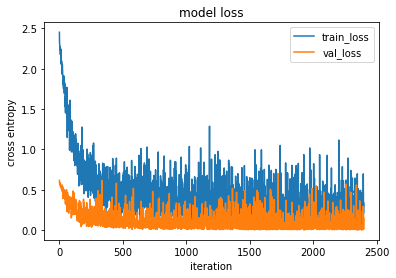

In [43]:
# 上記の学習で描画
learning_curve(2400, snn_t.cross_entropys, snn_t.cross_entropys_val)

- epoch毎ではなく、iteration毎にcross entropyを描画している
- 全体でみれは誤差は減少しているが、iteration毎の変動が大きい
- 1 epochで既に定常状態に入っているようにも見える

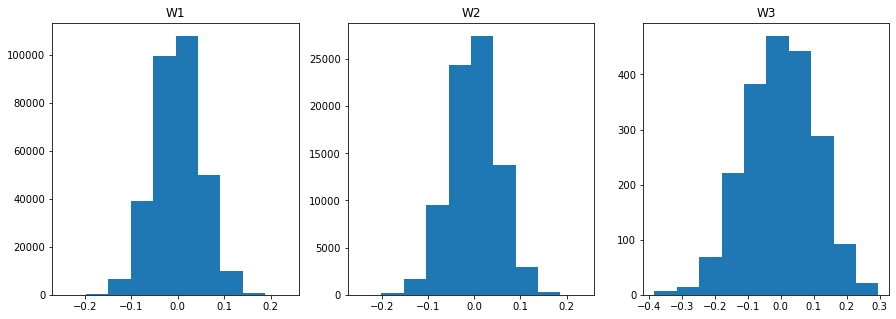

In [44]:
# 重みの分布確認
weights = [snn_t.W1, snn_t.W2, snn_t.W3]
plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title('W{}'.format(i+1))
    plt.hist(weights[i].flatten())
plt.show()

- 試しに重みの分布を確認してみたが、初期化から大きく変化したものは多くなさそう

### ＜ハイパーパラメーターの変更＞  
活性化関数、学習率、epoch数など各ハイパーパラメーターを変更し複数のモデルを試す。

== Scratch Neural Netrowk ==
( Activate : Sigmoid, Batch : 20, epoch : 1 )

< Lerning Curve >


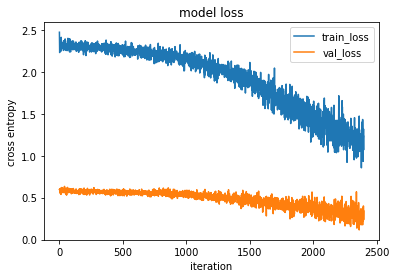

< Metrics >
Accuracy : 0.718


In [45]:
# 活性化関数をシグモイド関数とし、その他は問題6のまま
print('== Scratch Neural Netrowk ==')
print('( Activate : Sigmoid, Batch : 20, epoch : 1 )\n')
snn_s = ScratchSimpleNeuralNetrowkClassifier(n_nodes_1=400, 
                                             n_nodes_2=200,
                                             sigma=0.05,
                                             activate='sigmoid', 
                                             alpha=0.001, 
                                             batch_size=20, 
                                             epoch=1,
                                             verbose=False)
snn_s.fit(X_train, y_train, X_val, y_val)

# 学習曲線描画
print('< Lerning Curve >')
learning_curve(2400, snn_s.cross_entropys, snn_s.cross_entropys_val)

# Accuracy算出
print('< Metrics >')
y_pred = snn_s.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

- 同じ学習回数の$tanh$と比較し、$sigmoid$では学習が遅く途中で終わってしまった様子
- その分Accuracyも低くなっている
- 理由としては、$tanh$の方が変化が急であり勾配が大きいため、$sigmoid$よりも学習が早く進むものと思われる
- epoch数を増やせば、さらに学習が進んでいくだろう

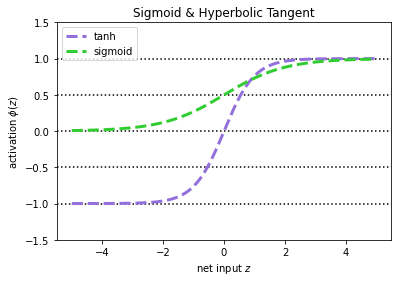

In [46]:
# sigmoid / tanh のグラフ
z = np.arange(-5, 5, 0.005)
sigmoid = expit(z)
tanh = np.tanh(z)
plt.ylim([-1.5, 1.5])
plt.xlabel('net input $z$')
plt.ylabel('activation $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')
plt.plot(z, tanh, linewidth=3, linestyle='--', label='tanh', color='mediumpurple')
plt.plot(z, sigmoid, linewidth=3, linestyle='--', label='sigmoid', color='limegreen')
plt.title('Sigmoid & Hyperbolic Tangent')
plt.legend()
plt.show()

== Scratch Neural Netrowk ==
( Activate : Hypaerbolic Tangent, Batch : 20, epoch : 10 )

< Lerning Curve >


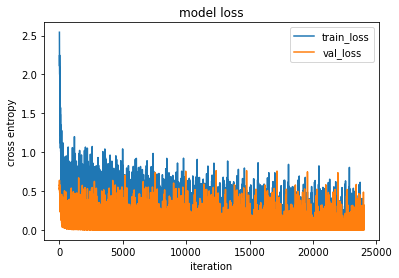

< Metrics >
Accuracy : 0.967


In [53]:
# epoch回数のみ増やす
print('== Scratch Neural Netrowk ==')
print('( Activate : Hypaerbolic Tangent, Batch : 20, epoch : 10 )\n')
snn_e = ScratchSimpleNeuralNetrowkClassifier(n_nodes_1=400, 
                                             n_nodes_2=200,
                                             sigma=0.05,
                                             activate='tanh', 
                                             alpha=0.001, 
                                             batch_size=20, 
                                             epoch=10,
                                             verbose=False)
snn_e.fit(X_train, y_train, X_val, y_val)

# 学習曲線描画
print('< Lerning Curve >')
learning_curve(24000, snn_e.cross_entropys, snn_e.cross_entropys_val)

# Accuracy算出
print('< Metrics >')
y_pred = snn_e.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

== Scratch Neural Netrowk ==
( Activate : Hypaerbolic Tangent, Batch : 200, epoch : 10 )

< Lerning Curve >


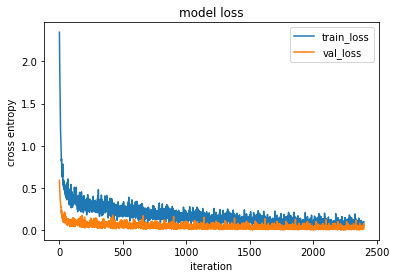

< Metrics >
Accuracy : 0.966


In [54]:
# バッチサイズとepoch回数を増やす
print('== Scratch Neural Netrowk ==')
print('( Activate : Hypaerbolic Tangent, Batch : 200, epoch : 10 )\n')
snn_b = ScratchSimpleNeuralNetrowkClassifier(n_nodes_1=400, 
                                             n_nodes_2=200,
                                             sigma=0.05,
                                             activate='tanh', 
                                             alpha=0.001, 
                                             batch_size=200, 
                                             epoch=10,
                                             verbose=False)
snn_b.fit(X_train, y_train, X_val, y_val)

# 学習曲線描画
print('< Lerning Curve >')
learning_curve(2400, snn_b.cross_entropys, snn_b.cross_entropys_val)

# Accuracy算出
print('< Metrics >')
y_pred = snn_b.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

- 問題 6 では 1epoch で既に定常状態に見えたが、epoch 数を増やすと性能が向上した
- 最終的な性能は僅差だが、バッチ数が少ない方はiteration毎のEntropyの変動が大きい
- 対してバッチ数とepoch数の両方を増やすと、確率的に変化する勾配ベクトルの向きがより適切になると考えられ、iteration毎の損失の変動が小さい
- バッチ数が大きいほうが、PCの処理時間も早い印象であった

== Scratch Neural Netrowk ==
( Activate : Hypaerbolic Tangent, Batch : 200, epoch : 10 )
( Node 1 : 40, Node 2 : 20)

< Lerning Curve >


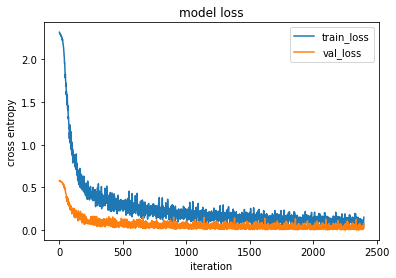

< Metrics >
Accuracy : 0.961


In [55]:
# 隠れ層のノードの数を減らす
print('== Scratch Neural Netrowk ==')
print('( Activate : Hypaerbolic Tangent, Batch : 200, epoch : 10 )')
print('( Node 1 : 40, Node 2 : 20)\n')
snn_n = ScratchSimpleNeuralNetrowkClassifier(n_nodes_1=40, 
                                             n_nodes_2=20,
                                             sigma=0.05,
                                             activate='tanh', 
                                             alpha=0.001, 
                                             batch_size=200, 
                                             epoch=10,
                                             verbose=False)
snn_n.fit(X_train, y_train, X_val, y_val)

# 学習曲線描画
print('< Lerning Curve >')
learning_curve(2400, snn_n.cross_entropys, snn_n.cross_entropys_val)

# Accuracy算出
print('< Metrics >')
y_pred = snn_n.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

- 各層のnode数を10分の1にしてみたが、十分に学習すれば良い精度は出せるようだ

### 【問題8】誤分類の確認  
誤分類した画像はどのようなものだったかを確認してください。推定値を用意し、以下のコードを実行してください。  


→　最も性能が高く安定していそうな、バッチ数とepoch数を増やしたモデルで誤分類を確認してみる。

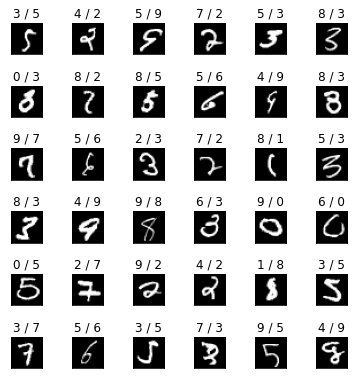

In [56]:
# 上記のうち、バッチ数とepoch数を増やしてモデルで予測を取得
y_pred = snn_b.predict(X_val)
# 誤分類
num = 36 # いくつ表示するか
true_false = y_pred==y_val
false_list = np.where(true_false==False)[0].astype(np.int)
if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')

- 誤分類例をみると、紛らわしく判断が難しいものが多い印象
- 2/3, 4/9, 5/3などの微妙な曲がり具合や、細長い1/7/8などが難しいようだ